In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/Users/mileslucas/dev/python/vampires_dpp/src")

# Polarimetric Differential Imaging (PDI)

This notebook shows a full example of PDI using some coronagraphic data taken in February 2022 of AB Aurigae. This notebook can be downloaded as **{nb-download}`polarimetric_differential_imaging.ipynb`**.

## Setup and Imports

In [2]:
from pathlib import Path
import vampires_dpp.mueller_matrices as mm
from astropy.io import fits
from zenodo_get import zenodo_get
import proplot as pro
import numpy as np

datadir = Path("data/hd36819_20220128/")
pro.rc["style"] = "ggplot"
pro.rc["image.origin"] = "lower"
pro.rc["image.cmap"] = "magma"

In [3]:
# download example data
zenodo_get(["10.5281/zenodo.7359198", "-o", datadir.parent.absolute()])

Title: VAMPIRES DPP Example Files
Keywords: 
Publication date: 2022-11-24
DOI: 10.5281/zenodo.7359198
Total size: 231.8 MB

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits   size: 100.0 MB
ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits   size: 31.0 MB
ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits   size: 100.0 MB
bench_CLC-3_750-50_LyotStop_00_cam1_calib.fits is already downloaded correctly.

Link: https://zenodo.org/api/files/a16d7d26-dcff-49c8-89f4-08e5c46c99ac/hd32297_20220225_headers.csv   size: 0.8 MB
hd32297_20220225_headers.csv is alre

## Pipeline processing

We will use the pipeline to process our data, making sure to set the `[polarimetry]` section. The below is the configuration file used for the pipeline-

<details>
<summary>hd36819_20220128_config.toml</summary>

```toml
version = "0.2.0" # vampires_dpp version

name = "hd36819_20220128"
target = "HD 36819"
directory = "data/hd36819_20220128"
output_directory = "data/hd36819_20220128/processed"
filenames = "HD36819*.fits"
frame_centers = [[119, 139], [124, 139]] # cam 1, cam 2 centers (x, y)

[calibration]
output_directory = "calibrated"

[frame_selection]
q = 0.5

[registration]
method = "peak"
output_directory = "registered"

[collapsing]
output_directory = "collapsed"

[derotate]
output_directory = "derotated"

[polarimetry]
method = "triplediff"
```
</details>

In [10]:
from vampires_dpp.pipeline import Pipeline

pipeline = Pipeline.from_file(datadir / "hd36819_20220128_config.toml")
pipeline.run()

Calibrating files:   0%|          | 0/8 [00:00<?, ?it/s]

Measuring frame selection metric:   0%|          | 0/16 [00:00<?, ?it/s]

Discarding frames:   0%|          | 0/16 [00:00<?, ?it/s]

Measuring frame offsets:   0%|          | 0/16 [00:00<?, ?it/s]

Aligning frames:   0%|          | 0/16 [00:00<?, ?it/s]

Collapsing frames:   0%|          | 0/16 [00:00<?, ?it/s]

Derotating frames:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/mileslucas/dev/python/vampires_dpp/src/vampires_dpp/polarization.py:47: RuntimeWarning: invalid value encountered in true_divide
  x = X / I
/Users/mileslucas/dev/python/vampires_dpp/src/vampires_dpp/polarization.py:47: RuntimeWarning: invalid value encountered in true_divide
  x = X / I


## Reviewing Outputs

In [5]:
stokes_cube = fits.getdata(datadir / "processed" / "hd36819_20220128_stokes_cube.fits")

from our Stokes cube we can calculate the polarized intensity (PI), angle of linear polarization (AoLP), and the radial Stokes parameters $Q_\phi$, $U_\phi$.

In [6]:
from vampires_dpp.polarization import radial_stokes

stokes_PI = np.hypot(stokes_cube[2], stokes_cube[1])
stokes_AoLP = np.arctan2(stokes_cube[2], stokes_cube[1])
Qphi, Uphi = radial_stokes(stokes_cube, phi=0)

let's plot our outputs (code hidden for brevity)

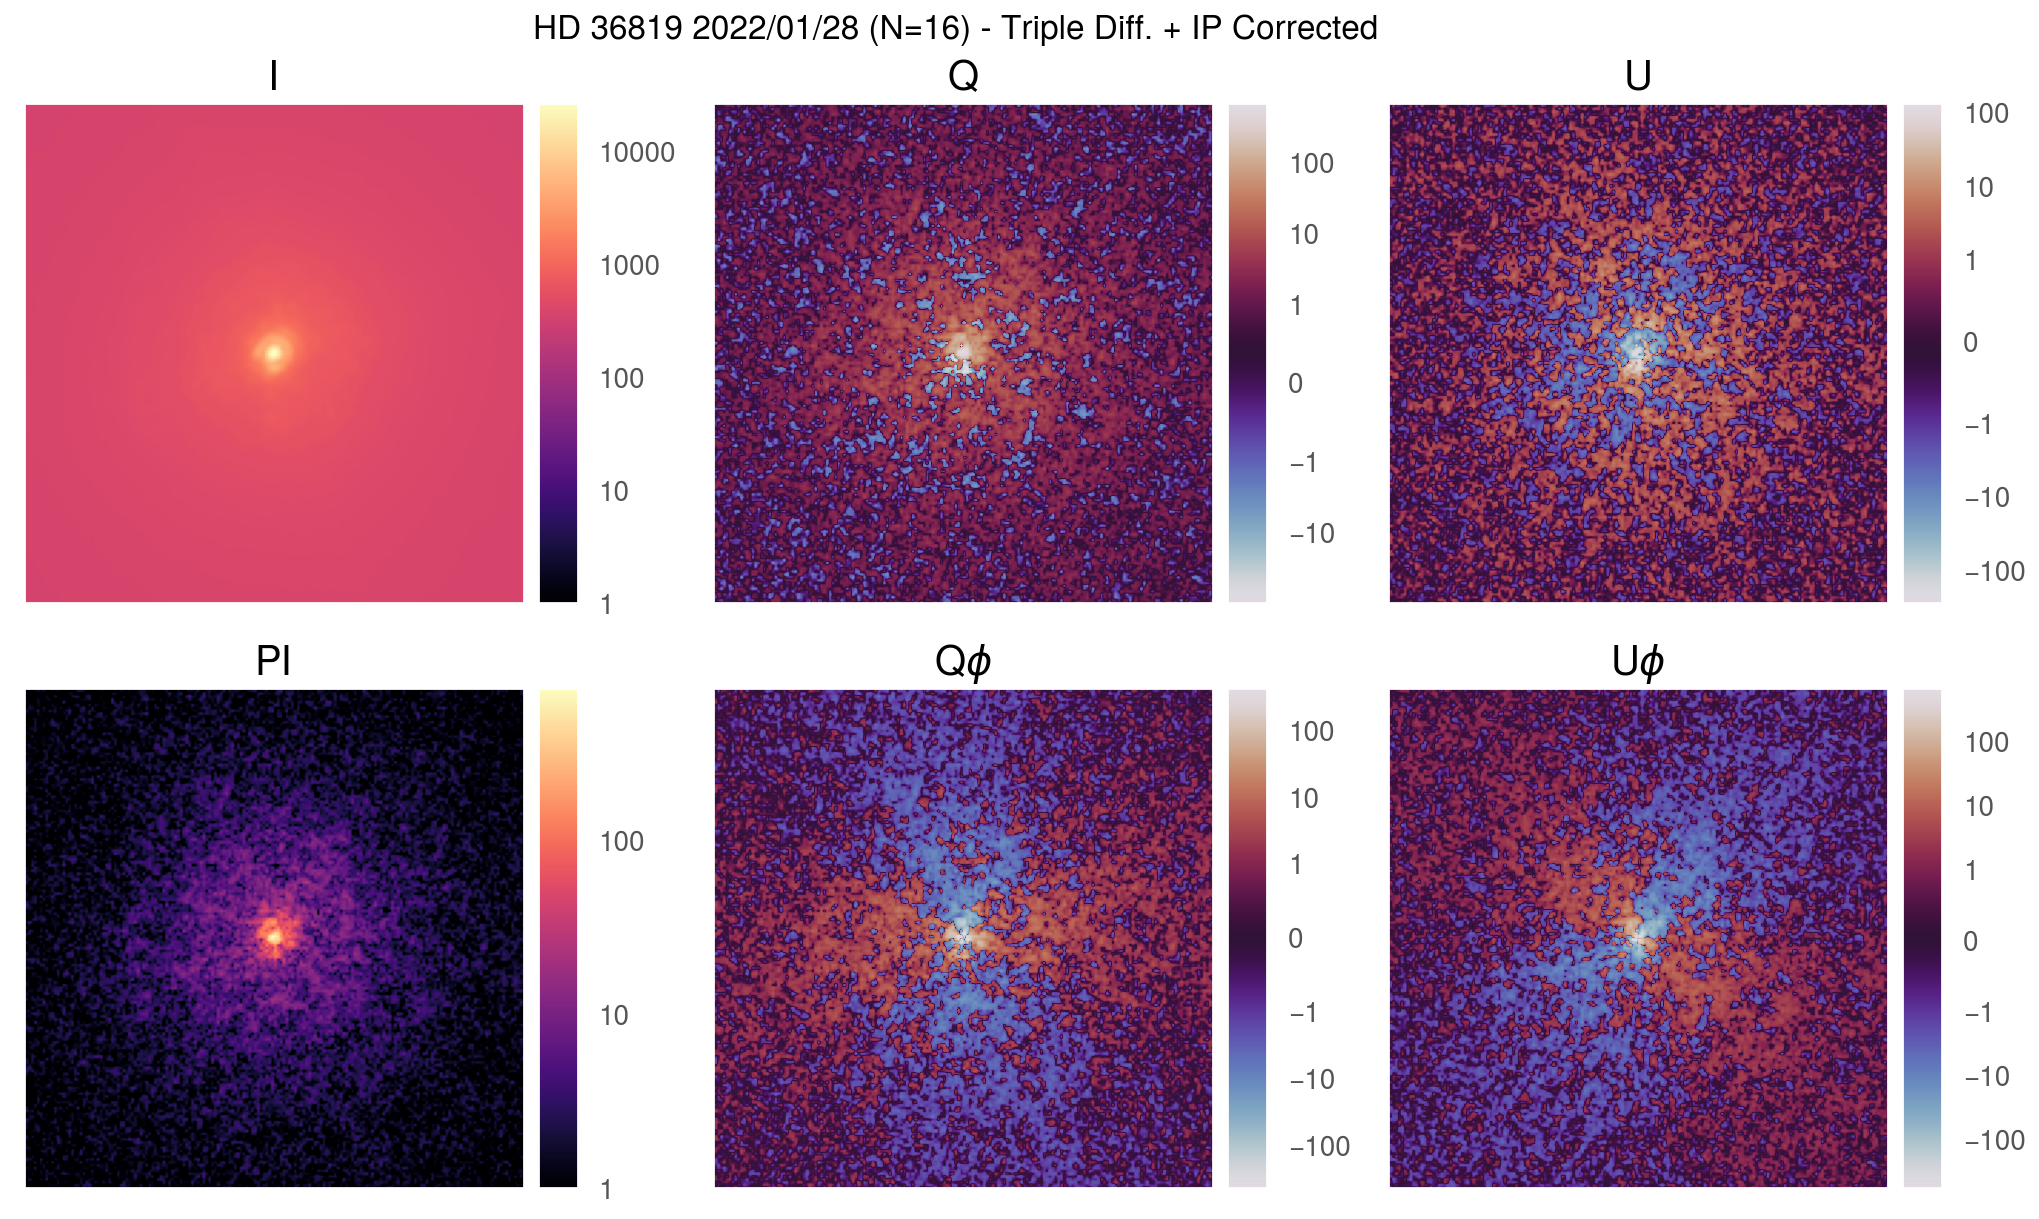

In [7]:
from matplotlib.patches import Circle, Rectangle
from vampires_dpp.image_processing import frame_center

plate_scale = 6.24
ctr = frame_center(stokes_cube)
titles = ("I", "Q", "U", "PI", "Q$\phi$", "U$\phi$")

fig, axes = pro.subplots(ncols=3, nrows=2, share=2)

im = axes[0, 0].imshow(stokes_cube[0], vmin=1, norm="log")
axes[0, 0].colorbar(im)
im = axes[0, 1].imshow(stokes_cube[1], cmap="twilight", norm="symlog")
axes[0, 1].colorbar(im)
im = axes[0, 2].imshow(stokes_cube[2], cmap="twilight", norm="symlog")
axes[0, 2].colorbar(im)

im = axes[1, 0].imshow(stokes_PI, vmin=1, norm="log")
axes[1, 0].colorbar(im)
im = axes[1, 1].imshow(Qphi, cmap="twilight", norm="symlog")
axes[1, 1].colorbar(im)
im = axes[1, 2].imshow(Uphi, cmap="twilight", norm="symlog")
axes[1, 2].colorbar(im)

[axes[i].format(title=titles[i]) for i in range(6)]

width = 175
axes.format(
    xticks=False,
    yticks=False,
    xlim=(ctr[0] - width/2, ctr[0] + width/2),
    ylim=(ctr[1] - width/2, ctr[1] + width/2)
)
fig.suptitle("HD 36819 2022/01/28 (N=16) - Triple Diff. + IP Corrected");

## Measuring Polarimetric Efficiency